# Wrapping the Boundary: Neural Network Shape Classification
## Using Custom Activation Functions and Geometric Constraints  

### Exploring Polygon Boundaries Approximation with ReLU Neurons and AND Logic  

This notebook presents a **geometric approach** to binary shape classification using neural networks with **custom activation functions**.  
The key idea is a **multiply-all operation** that acts as a **logical AND** over half-plane constraints, enabling the model to learn convex polygon boundaries with clear geometric meaning.

---

## Table of Contents
- [1. Setup and Import Libraries](#1-setup-and-import-libraries)
- [2. Mathematical Foundation](#2-mathematical-foundation)
- [3. Custom Activation Functions](#3-custom-activation-functions)
- [4. Data Generation Functions](#4-data-generation-functions)
- [5. Model Architecture and Weight Initialization](#5-model-architecture-and-weight-initialization)
- [6. Training and Visualization Functions](#6-training-and-visualization-functions)
- [7. Main Model Runner Function](#7-main-model-runner-function)
- [8. Shape Classification Examples](#8-shape-classification-examples)
- [9. Results Analysis and Comparison](#9-results-analysis-and-comparison)
- [10. Conclusion and Next Steps](#10-conclusion-and-next-steps)

---

## Abstract

We explore the application of **custom-activated neural networks** for geometric shape classification.  
The network approximates convex polygon boundaries using **ReLU half-planes** combined with **logical AND via multiplication**.

**Key contributions:**
- Introduce a **multiply-all activation** that acts like an AND gate for half-planes
- Use **geometric weight initialization** to make polygon boundaries easier to learn
- Run **interactive experiments** on a variety of shapes
- Analysis of **convexity constraints** in NN architectures

**Note:** Accuracy over the full domain may overestimate performance for small shapes, because most exterior points are trivially classified.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; IoU (Intersection over Union) is a better measure of shape-specific performance.

---

## Example Output Preview

Here are some example classification results produced by the model:  

### Convex Shapes (Excellent/Good Performance)

| Circle | Ellipse |  
|--------|---------|
| ![Circle](https://raw.githubusercontent.com/Dani-Luk/kaggle-wrapping-convex-shape-classifier/main/assets/output_circle.png) | ![Ellipse](https://raw.githubusercontent.com/Dani-Luk/kaggle-wrapping-convex-shape-classifier/main/assets/output_ellipse.png) | 

| Triangle | House Shape |
|----------|-------------|
| ![Triangle](https://raw.githubusercontent.com/Dani-Luk/kaggle-wrapping-convex-shape-classifier/main/assets/output_some_triangle.png) | ![House](https://raw.githubusercontent.com/Dani-Luk/kaggle-wrapping-convex-shape-classifier/main/assets/output_house-shape.png) |
### Non-Convex Shapes (Shows Method Limitations)

| L-Shape | S-Shape |
|---------|---------|
| ![L-Shape](https://raw.githubusercontent.com/Dani-Luk/kaggle-wrapping-convex-shape-classifier/main/assets/output_L-shape.png) | ![S-Shape](https://raw.githubusercontent.com/Dani-Luk/kaggle-wrapping-convex-shape-classifier/main/assets/output_S-shape.png) |




## 1. Setup and Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Lambda
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
import os
import random
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib style for better visualizations
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

def set_random_seed(seed: int):
    """Set random seed for reproducible results across all libraries"""
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    print(f"Random seed set to: {seed}")

TensorFlow version: 2.18.0
NumPy version: 1.26.0


## 2. Mathematical Foundation

### Polygon Approximation with Neural Networks

The core idea is to approximate convex polygons using neural networks where:

1. **ReLU Neurons as Half-Planes**: Each ReLU neuron represents a half-plane constraint:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ \text{ReLU}(w_1 x + w_2 y + b) = \max(0, w_1 x + w_2 y + b) $


2. **AND Logic via Multiplication**: The intersection of multiple half-planes (forming a convex polygon) is achieved through multiplication:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ \text{polygon-interior} = \prod_i \text{ReLU}(w_{i1} x + w_{i2} y + b_i) $



3. **Geometric Interpretation**: 
   - Each ReLU activation creates a binary decision boundary
   - Multiplication ensures ALL constraints must be satisfied
   - The result approximates the interior of a convex polygon

### Why MSE vs Binary Crossentropy?

Due to the custom multiply-all activation and steep sigmoid (20x scaling), Mean Squared Error provides more stable gradients than binary crossentropy, which can become unstable with extreme probability values.


## 3. Custom Activation Functions

The heart of our approach lies in custom activation functions that implement AND logic through multiplication operations. We provide two variants:

In [2]:
@tf.custom_gradient
def multiply_and_activation(inputs):
    """
    Custom activation function that multiplies all inputs (AND logic).
    
    This implements the core idea: intersection of half-planes requires
    ALL ReLU constraints to be satisfied simultaneously.
    
    Args:
        inputs: Tensor of ReLU outputs from polygon layer
        
    Returns:
        Product of all inputs with custom gradients
    """
    def gradient_fn(dy):
        # Custom gradient: ∂(∏xᵢ)/∂xⱼ = (∏xᵢ)/xⱼ
        product_all = tf.reduce_prod(inputs, axis=-1, keepdims=True)
        grad_inputs = [dy * (product_all / (inputs[..., i:i+1] + 1e-8))
                       for i in range(inputs.shape[-1])]
        return tf.concat(grad_inputs, axis=-1)
    
    return tf.reduce_prod(inputs, axis=-1, keepdims=True), gradient_fn


@tf.custom_gradient
def log_multiply_and_activation(inputs):
    """
    Alternative activation using log-sum approach for numerical stability.
    
    Uses log-space arithmetic: log(∏xᵢ) = ∑log(xᵢ)
    More stable for many inputs but changes the mathematical interpretation.
    """
    log_sum = 2 + tf.reduce_sum(tf.math.log(inputs + 1e-6), axis=-1, keepdims=True)
    
    def gradient_fn(dy):
        return dy / (inputs + 1e-6)
    
    return log_sum, gradient_fn

# Test the custom activations
print("✓ Custom activation functions defined successfully")

✓ Custom activation functions defined successfully


## 4. Data Generation Functions

We implement robust data generation for various geometric shapes using mathematical algorithms for point-in-shape testing.

In [3]:
def generate_circle_data(n_samples=2000, radius_x=1.0, radius_y=1.0):
    """
    Generate binary classification data for ellipse/circle shapes.
    
    Args:
        n_samples: Number of random points to generate
        radius_x: Semi-axis length in x direction
        radius_y: Semi-axis length in y direction
        
    Returns:
        X: Array of 2D points
        y: Binary labels (1=inside, 0=outside)
    """
    X = np.random.uniform(-2.5, 2.5, size=(n_samples, 2))
    
    # Ellipse equation: (x/a)² + (y/b)² < 1
    inside_ellipse = (X[:, 0]**2 / radius_x**2 + X[:, 1]**2 / radius_y**2) < 1
    y = inside_ellipse.astype(np.float32)
    
    return X, y


def generate_polygon_data(n_samples=2000, corners=None):
    """
    Generate binary classification data for N-sided polygons using ray casting.
    
    Args:
        n_samples: Number of random points to generate
        corners: List of N vertices in counter-clockwise order
        
    Returns:
        X: Array of 2D points
        y: Binary labels (1=inside, 0=outside)
        corners: Polygon vertices used
    """
    if corners is None:
        # Default: Equilateral triangle
        corners = [(0, 1.5), (-1.3, -0.75), (1.3, -0.75)]
    
    X = np.random.uniform(-3, 3, size=(n_samples, 2))
    
    def point_in_polygon(point, polygon_corners):
        """Ray casting algorithm for point-in-polygon test"""
        x, y = point
        n = len(polygon_corners)
        inside = False
        
        p1x, p1y = polygon_corners[0]
        for i in range(1, n + 1):
            p2x, p2y = polygon_corners[i % n]
            if y > min(p1y, p2y):
                if y <= max(p1y, p2y):
                    if x <= max(p1x, p2x):
                        if p1y != p2y:
                            xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                        if p1x == p2x or x <= xinters:
                            inside = not inside
            p1x, p1y = p2x, p2y
        return inside
    
    y = np.array([point_in_polygon(point, corners) for point in X]).astype(np.float32)
    return X, y, corners

print("✓ Data generation functions ready")
print("  - Circle/Ellipse generation")
print("  - Polygon generation (ray casting algorithm) - includes triangles as special case")

✓ Data generation functions ready
  - Circle/Ellipse generation
  - Polygon generation (ray casting algorithm) - includes triangles as special case


## 5. Model Architecture and Weight Initialization

The model architecture consists of:
1. **Polygon Layer**: Dense layer with ReLU activation (represents half-planes)
2. **Custom Activation**: Multiply-all operation (implements AND logic)  
3. **Output Layer**: Single neuron with strong sigmoid scaling

In [4]:
def initialize_circle_weights(n_sides=6, radius=2.0):
    """
    Initialize polygon layer weights to approximate a circle.
    The catches: 
        - keep left! ;) when generating the polygon so the inside and outside will be well classified ;) 
        - choose a radius large enough to contain the shape, 
        and don't forget to leave enough points outside, to have thereby good examples outside 
        and so the model will be able to start the learning process

    This geometric initialization ensures the model starts with a reasonable
    approximation rather than random weights.
    
    Args:
        n_sides: Number of polygon sides (hyperplanes)
        radius: Initial radius of the approximated circle
        
    Returns:
        weights: Weight matrix [2, n_sides] 
        biases: Bias vector [n_sides]
    """
    assert n_sides > 2, "Number of sides must be greater than 2 anyway"
    angles = np.linspace(0, 2 * np.pi, n_sides, endpoint=False)
    
    # Each column represents a hyperplane normal vector
    weights = np.stack([np.cos(angles), np.sin(angles)], axis=1).T / 2
    biases = radius * np.ones(n_sides) / 2
    
    return weights, biases


def build_model(n_sides=6, custom_activation_fn=multiply_and_activation):
    """
    Build the neural network architecture for shape classification.
    
    Architecture:
    Input(2D) → Dense(n_sides, ReLU) → Custom_Activation → Dense(1, Sigmoid) → Output
    
    Args:
        n_sides: Number of polygon sides (hyperplanes)
        custom_activation_fn: multiply_and_activation or log_multiply_and_activation
        
    Returns:
        Compiled Keras model
    """
    # Input layer (x, y coordinates)
    input_layer = Input(shape=(2,), name='coordinates')
    
    # Polygon layer: each neuron represents a half-plane constraint
    polygon_layer = Dense(n_sides, activation='relu', name='polygon')(input_layer)
    
    # Custom activation: implement AND logic through multiplication
    and_operation = Lambda(custom_activation_fn, name='and_logic')(polygon_layer)
    
    # Output layer with strong sigmoid scaling for sharp decision boundaries
    output_layer = Dense(
        1,
        activation=lambda x: tf.sigmoid(20 * x),  # Strong sigmoid for sharp boundaries
        kernel_initializer=tf.keras.initializers.Constant([[10.0]]),  # Positive weight initialization! (from 1-st layer comes with '+' for class 1)
        # kernel_initializer=tf.keras.initializers.Constant([[2.0]]),  # try this to see diff
        bias_initializer=tf.keras.initializers.Zeros(),
        name='classification_output'
    )(and_operation)
    
    # Create and compile model
    model = Model(inputs=input_layer, outputs=output_layer, name='ShapeClassifier')
    
    # Use MSE instead of binary_crossentropy due to extreme sigmoid scaling
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['accuracy']
    )
    
    return model


def validate_model_initialization(model):
    """
    Validate that the model initialization is correct by testing the origin.

    The origin (0,0) should be classified as inside (class=1) for proper initialization. (and layer 2 positive initialization!)
    """
    origin_prediction = model.predict(np.array([[0.0, 0.0]]), verbose=0)[0][0]
    
    try:
        assert origin_prediction > 0.5, f"Origin prediction should be > 0.5, got {origin_prediction:.4f}"
        print(f"✓ Model initialization checked! (origin prediction = {origin_prediction:.4f})")
        return True
    except AssertionError as e:
        print(f"✗ Model initialization failed: {e}")
        return False

print("✓ Model architecture functions ready")

✓ Model architecture functions ready


## 6. Training and Visualization Functions

These functions handle model training with a freeze-unfreeze strategy and provide comprehensive visualization of results.

In [5]:
def plot_true_boundary_approximation(X, y, lstAxes, x_range=(-3, 3), color='yellow', alpha=0.7, resolution=100):
    """
    Plot true boundary approximated from actual data points using meshgrid to multiple axes
    
    OPTIMIZED VERSION:
    - Reduced default resolution from 200 to 100 (4x fewer points: 10k vs 40k)
    - Uses KDTree for O(N log N) nearest neighbor search instead of O(N²) cdist
    - Configurable resolution parameter
    - Memory-efficient processing
    """
    from scipy.spatial import KDTree
    
    # Create mesh grid with configurable resolution
    xx, yy = np.meshgrid(np.linspace(*x_range, resolution), np.linspace(*x_range, resolution))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Use KDTree for much faster nearest neighbor search
    # KDTree: O(N log N) vs cdist: O(N²)
    print(f"Building KDTree for {len(X)} data points...")
    tree = KDTree(X)
    
    # Find closest data points (much faster than cdist)
    print(f"Finding nearest neighbors for {len(grid_points)} grid points...")
    _, closest_indices = tree.query(grid_points)
    grid_true_labels = y[closest_indices].reshape(xx.shape)
    
    for ax in lstAxes:
        # Plot the true boundary approximation
        ax.contour(xx, yy, grid_true_labels, levels=[0.5], colors=[color], 
                  linewidths=2, linestyles='-.', alpha=alpha)

def plot_true_boundary_approximation_fast(X, y, lstAxes, x_range=(-3, 3), color='yellow', alpha=0.7, resolution=80):
    """
    ULTRA-FAST VERSION: Even more aggressive optimizations
    - Lower default resolution (80x80 = 6,400 points)
    - Batch processing for very large datasets
    - Early termination options
    
    NOTE: This function is kept for future comparison but not used in the main pipeline
    """
    from scipy.spatial import KDTree
    
    # For very large datasets, subsample for boundary approximation
    if len(X) > 5000:
        print(f"Large dataset detected ({len(X)} points), subsampling for boundary approximation...")
        # Sample points near the boundary (mix of inside/outside points)
        inside_idx = np.where(y == 1)[0]
        outside_idx = np.where(y == 0)[0]
        
        # Take a balanced sample
        n_sample = min(2500, len(inside_idx), len(outside_idx))
        sample_inside = np.random.choice(inside_idx, n_sample, replace=False)
        sample_outside = np.random.choice(outside_idx, n_sample, replace=False)
        
        sample_idx = np.concatenate([sample_inside, sample_outside])
        X_sample = X[sample_idx]
        y_sample = y[sample_idx]
    else:
        X_sample = X
        y_sample = y
    
    # Create smaller mesh grid
    xx, yy = np.meshgrid(np.linspace(*x_range, resolution), np.linspace(*x_range, resolution))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Use KDTree on sampled data
    tree = KDTree(X_sample)
    _, closest_indices = tree.query(grid_points)
    grid_true_labels = y_sample[closest_indices].reshape(xx.shape)
    
    for ax in lstAxes:
        ax.contour(xx, yy, grid_true_labels, levels=[0.5], colors=[color], 
                  linewidths=2, linestyles='-.', alpha=alpha)

def plot_dataset_predictions_and_boundaries(model, X, y_true, lstAxes, x_range=(-3, 3), resolution=100):
    """
    Plot dataset with model predictions and boundaries by showing correct/incorrect classifications to multiple axes
    OPTIMIZED: Changed default resolution from 150 to 100 for better performance
    """
    # Get model predictions (calculate once, reuse for all axes)
    y_pred = model.predict(X, verbose=0).flatten()
    pred_labels = (y_pred > 0.5).astype(int)
    
    # Create background grid for prediction visualization with configurable resolution
    xx, yy = np.meshgrid(np.linspace(*x_range, resolution), np.linspace(*x_range, resolution))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_pred = model.predict(grid_points, verbose=0).reshape(xx.shape)
    binary_grid = (grid_pred > 0.5).astype(int)
    
    for ax in lstAxes:
        # Plot prediction background
        ax.pcolormesh(xx, yy, binary_grid, cmap='RdYlBu', shading='auto', alpha=0.2)
        # Plot the 0.5 probability contour (decision boundary)
        ax.contour(xx, yy, grid_pred, levels=[0.5], colors=['brown'], linewidth=2, linestyle='--')

    # Plot points with correct/incorrect markers
    for i in range(len(X)):
        correct = (pred_labels[i] == y_true[i])
        color = 'red' if pred_labels[i] == 1 else 'blue'
        marker = 'o' if correct else 'x'
        size = 15 if correct else 25
        for ax in lstAxes:
            ax.scatter(X[i, 0], X[i, 1], c=color, marker=marker, 
                s=size, alpha=0.7, edgecolors='black', linewidth=0.5)


def plot_model_weights_lines(model, lstAxes, x_range=(-3, 3), color='green', alpha=0.8, ):
    """Plot the model weighs lines to multiple axes"""
    # Get  model weights
    weights, biases = model.get_layer('polygon').get_weights()
    x_vals = np.linspace(*x_range, 2)

    for i in range(weights.shape[1]):
        w1, w2 = weights[:, i]
        bias = biases[i]
        if abs(w2) > 1e-8:  # Non-vertical line
            y_vals = -(w1 * x_vals + bias) / w2
            for ax in lstAxes:
                ax.plot(x_vals, y_vals, color=color, linestyle='-', 
                        linewidth=1.2, alpha=alpha,
                        )
        else:  # Vertical line
            x_line = -bias / w1
            for ax in lstAxes:
                ax.axvline(x=x_line, color=color, linestyle='-', 
                           linewidth=1.2, alpha=alpha, 
                           )
    return

def compute_iou(y_true, y_pred_probs, threshold=0.5):
    """Compute Intersection over Union (IoU) for binary classification."""
    y_pred = (y_pred_probs > threshold).astype(int)
    intersection = np.sum((y_true == 1) & (y_pred == 1))
    union = np.sum((y_true == 1) | (y_pred == 1))
    return intersection / (union + 1e-8)


def train_output_layer(model, X_train, y_train, X_val, y_val, epochs_output_only=10, verbose=False):
    """
    Train only the output layer of the model using freezing first layer. 
    """
    print(f"Phase 1: Training ({epochs_output_only} epochs) output layer only")
    model.get_layer('polygon').trainable = False
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    history1 = model.fit(X_train, y_train, epochs=epochs_output_only, batch_size=32, 
                        validation_data=(X_val, y_val), verbose=verbose)

    # Unfreeze polygon layer for next phase, and recompile model
    model.get_layer('polygon').trainable = True
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    return


def train_all_layers(model, X_train, y_train, X_val, y_val, epochs_all_layers=70, verbose=False):
    """
    Train all layers of the model.
    """

    print(f"Phase 2: Training ({epochs_all_layers} epochs) all layers")

    history2 = model.fit(X_train, y_train, epochs=epochs_all_layers, batch_size=32,
                        validation_data=(X_val, y_val), verbose=verbose)
    
    # Compute IoU for validation set
    val_pred_probs = model.predict(X_val, verbose=0).flatten()
    validation_iou = compute_iou(y_val, val_pred_probs)
    print(f"Validation IoU: {validation_iou:.4f}")
    
    return validation_iou

print("✓ Visualization and training functions ready")

✓ Visualization and training functions ready


## 7. Main Model Runner Function

The central function that orchestrates the entire pipeline from data generation to model evaluation using IoU as the primary metric.

In [6]:
def run_model(shape_type, custom_activation_fn=multiply_and_activation, n_sides=12, 
              random_seed=None, n_samples=3000, resolution=100,
              **shape_kwargs):
    """
    Complete pipeline for shape classification experiments.
    
    PERFORMANCE OPTIMIZATIONS ADDED:
    - resolution: Grid density for both boundary and prediction visualization (default 100, was 200)
    - Uses KDTree for O(N log N) nearest neighbor search instead of O(N²) cdist
    
    Args:
        shape_type: name = 'circle/ellipse', 'triangle', etc treated as 'polygon'
        custom_activation_fn: multiply_and_activation or log_multiply_and_activation
        n_sides: Number of polygon sides (hyperplanes) in the model
        random_seed: Random seed for reproducibility (None = random)
        n_samples: Number of data points to generate
        resolution: Grid resolution for visualization (lower = faster, higher = better quality)
        **shape_kwargs: Additional parameters for shape generation
        
    Returns:
        dict: Results including model, IoU, and metadata
    """
    
    # Set random seed
    if random_seed is None:
        random_seed = random.randint(1, 1000)
    set_random_seed(random_seed)
    
    print(f"\n{'='*60}")
    print(f"RUNNING Shape: {shape_type.upper()}")
    print(f"Activation: {custom_activation_fn.__name__}")
    print(f"Polygon sides: {n_sides}")
    print(f"Random seed: {random_seed}")
    print(f"{'='*60}")
    
    # Generate data based on shape type
    if shape_type in ['circle', 'ellipse']:
        X, y = generate_circle_data(n_samples, **shape_kwargs)
        corners = None
        print(f"Generated {len(X)} points for {shape_type}")
    else: # assuming that all other shapes are polygons
        X, y, corners = generate_polygon_data(n_samples, **shape_kwargs)
        print(f"Generated {len(X)} points for {shape_type}")
        
    # else:
    #     raise ValueError(f"Unknown shape_type: {shape_type}")
    
    print(f"Inside points: {np.sum(y)}/{len(y)} ({100*np.sum(y)/len(y):.1f}%)")
    
    # Split data

    print("Splitting data.", end=' ')
    # First split: train + temp (validation + test)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

    # Second split temp: validation + test
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    # Build and initialize model
    print("Building model.", end=' ')
    model = build_model(n_sides, custom_activation_fn)
    
    # Initialize with circle approximation
    print("Initializing model weights.", end=' ')
    weights, biases = initialize_circle_weights(n_sides, radius=2.0)
    model.get_layer('polygon').set_weights([weights, biases])
    
    # Validate initialization
    validation_passed = validate_model_initialization(model)
    
    if not validation_passed:
        print("⚠️  Model initialization validation failed - results may be poor")
    
    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))


    print(f"Phase 0.1: Training ({10} epochs) output layer only")
    train_output_layer(model, X_train, y_train, X_val, y_val, epochs_output_only=10, verbose=False)
    
    # === AX1: Initial State (Whole Dataset) ===
    # Plot initial model boundaries to all axes
    # Calculate IoU for titles
    print("Plotting initial model boundaries...")
    init_all_pred_probs = model.predict(X, verbose=0).flatten()
    init_all_iou = compute_iou(y, init_all_pred_probs)
    # plot_model_weights_lines(model, lstAxes=[ax1, ax2, ax3], color='grey', alpha=0.8)
    plot_model_weights_lines(model, lstAxes=[ax1, ax2, ax3], color='cyan', alpha=0.4)
    
    # Use optimized plotting function with configurable resolution
    plot_true_boundary_approximation(X, y, lstAxes=[ax1, ax2, ax3], resolution=resolution)
    
    plot_dataset_predictions_and_boundaries(model, X, y, lstAxes=[ax1], resolution=resolution)

    # Setup ax1
    # Add manual legend entry for ax1
    ax1.plot([], [], color='cyan', linestyle='-', linewidth=1, label='Initial Lines')
    ax1.plot([], [], color='yellow', linestyle='-.', linewidth=1, alpha=0.7, label='True Boundary')
    ax1.plot([], [], color='brown', linestyle='-', linewidth=1, label='Model Boundary')
    ax1.plot([], [], color='red', linestyle='-', linewidth=1, label='Inside')
    ax1.plot([], [], color='blue', linestyle='-', linewidth=1, label='Outside')
    
    ax1.set_aspect('equal')
    ax1.grid(True, alpha=0.3)
    ax1.set_title(f'{shape_type} - Initial State\n( all_IoU = {init_all_iou:.3f} )')
    ax1.set_xlim(-3, 3)
    ax1.set_ylim(-3, 3)
    ax1.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98))
    
    #  Train model
    print(f"\nTraining model...")
    val_iou = train_all_layers(model, X_train, y_train, X_val, y_val)
    train_pred_probs = model.predict(X_train, verbose=0).flatten()
    train_iou = compute_iou(y_train, train_pred_probs)

    print("Plotting trained model boundaries...")
    # === AX2: After Training (Training Data & Validation ) ===
    # plot model boundaries to ax2 AND ax3
    plot_model_weights_lines(model, lstAxes=[ax2, ax3], color='green', alpha=0.8, )
    # plot_true_boundary_approximation(X, y, lstAxes=[ax2, ax3], color='brown', alpha=0.6, label='True Boundary') # already plotted
    plot_dataset_predictions_and_boundaries(model, X_train, y_train, lstAxes=[ax2], resolution=resolution)

    # Setup ax2
    # Add manual legend entry for ax2
    ax2.plot([], [], color='cyan', linestyle='-', linewidth=1, label='Initial Lines')
    ax2.plot([], [], color='yellow', linestyle='-.', linewidth=1, alpha=0.7, label='True Boundary')
    ax2.plot([], [], color='brown', linestyle='-', linewidth=1, label='Model Boundary')
    ax2.plot([], [], color='green', linestyle='-', linewidth=1, label='Trained Lines')
    ax2.plot([], [], color='red', linestyle='-', linewidth=1, label='Inside')
    ax2.plot([], [], color='blue', linestyle='-', linewidth=1, label='Outside')

    ax2.set_aspect('equal')
    ax2.grid(True, alpha=0.3)
    ax2.set_title(f'{shape_type} - Trained State\n( train_IoU = {train_iou:.3f} / val_IoU = {val_iou:.3f} )')
    ax2.set_xlim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax2.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98))

    # TEST model
    print(f"\nTesting model...")
    test_pred_probs = model.predict(X_test, verbose=0).flatten()
    test_iou = compute_iou(y_test, test_pred_probs)
    print(f"Test IoU: {test_iou:.4f} ")
    print("Plotting test model boundaries...")
    # === AX3: TEST results ===
    plot_dataset_predictions_and_boundaries(model, X_test, y_test, lstAxes=[ax3], resolution=resolution)

    # Setup ax3
    # Add manual legend entry for ax3
    ax3.plot([], [], color='cyan', linestyle='-', linewidth=1, label='Initial Lines')
    ax3.plot([], [], color='yellow', linestyle='-.', linewidth=1, alpha=0.7, label='True Boundary')
    ax3.plot([], [], color='brown', linestyle='-', linewidth=1, label='Model Boundary')
    ax3.plot([], [], color='green', linestyle='-', linewidth=1, label='Trained Lines')
    ax3.plot([], [], color='red', linestyle='-', linewidth=1, label='Inside')
    ax3.plot([], [], color='blue', linestyle='-', linewidth=1, label='Outside')

    ax3.set_aspect('equal')
    ax3.grid(True, alpha=0.3)
    ax3.set_title(f'{shape_type} - Test Results\n( test_IoU = {test_iou:.3f} )')
    ax3.set_xlim(-3, 3)
    ax3.set_ylim(-3, 3)
    ax3.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98))

    plt.tight_layout()
    plt.show()

    # Return results
    results = {
        'model': model,
        'iou': val_iou,
        'shape_type': shape_type,
        'activation_function': custom_activation_fn.__name__,
        'n_sides': n_sides,
        'random_seed': random_seed,
        'data_size': len(X),
        'corners': corners,
        'validation_passed': validation_passed
    }
    
    return results

print("✓ Main model runner function ready")

✓ Main model runner function ready


## 8. Shape Classification Examples

Now let's run experiments on various geometric shapes to demonstrate the versatility of our approach.

**Expected Results Preview**: *[Placeholder for result screenshots showing classification IoU and decision boundaries for each shape type]*

### 8.1 Circle Classification

Random seed set to: 42

RUNNING Shape: CIRCLE
Activation: multiply_and_activation
Polygon sides: 5
Random seed: 42
Generated 3000 points for circle
Inside points: 392.0/3000 (13.1%)
Splitting data. Building model. WARNING:tensorflow:From c:\Users\dluka\miniconda3\envs\myai\Lib\site-packages\keras\src\backend\tensorflow\core.py:204: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

Initializing model weights. ✓ Model initialization checked! (origin prediction = 1.0000)
Phase 0.1: Training (10 epochs) output layer only
Phase 1: Training (10 epochs) output layer only
Plotting initial model boundaries...
Building KDTree for 3000 data points...
Finding nearest neighbors for 10000 grid points...

Training model...
Phase 2: Training (70 epochs) all layers
Validation IoU: 0.9630
Plotting trained model boundaries...

Testing model...
Test IoU: 0.9730 
Plotting test model boundaries...


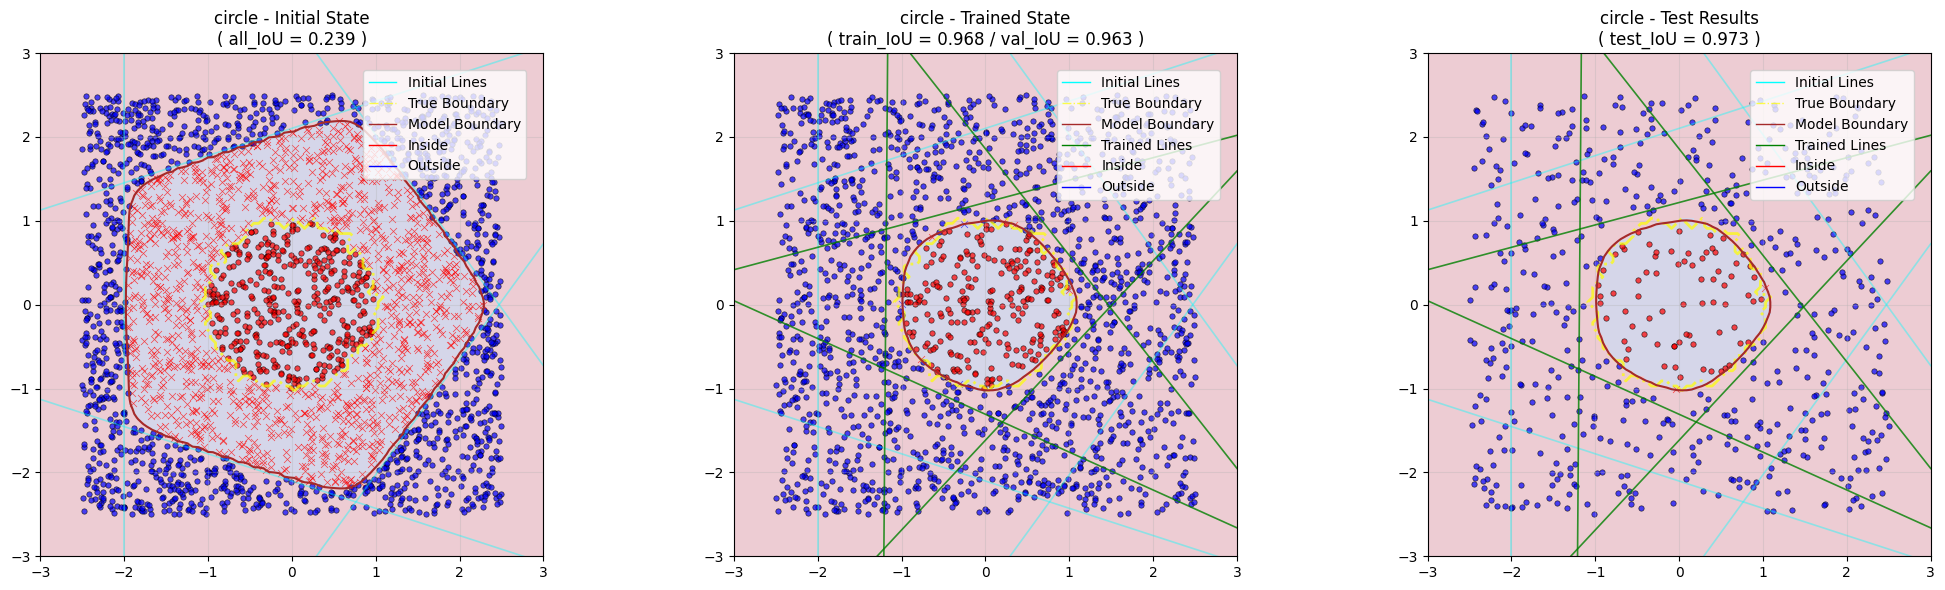

In [7]:
# Perfect circle
circle_results = run_model('circle', n_sides=5, random_seed=42, radius_x=1.0, radius_y=1.0)

Random seed set to: 42

RUNNING Shape: ELLIPSE
Activation: multiply_and_activation
Polygon sides: 8
Random seed: 42
Generated 3000 points for ellipse
Inside points: 466.0/3000 (15.5%)
Splitting data. Building model. Initializing model weights. ✓ Model initialization checked! (origin prediction = 1.0000)
Phase 0.1: Training (10 epochs) output layer only
Phase 1: Training (10 epochs) output layer only
Plotting initial model boundaries...
Building KDTree for 3000 data points...
Finding nearest neighbors for 10000 grid points...

Training model...
Phase 2: Training (70 epochs) all layers
Validation IoU: 0.9783
Plotting trained model boundaries...

Testing model...
Test IoU: 0.9655 
Plotting test model boundaries...


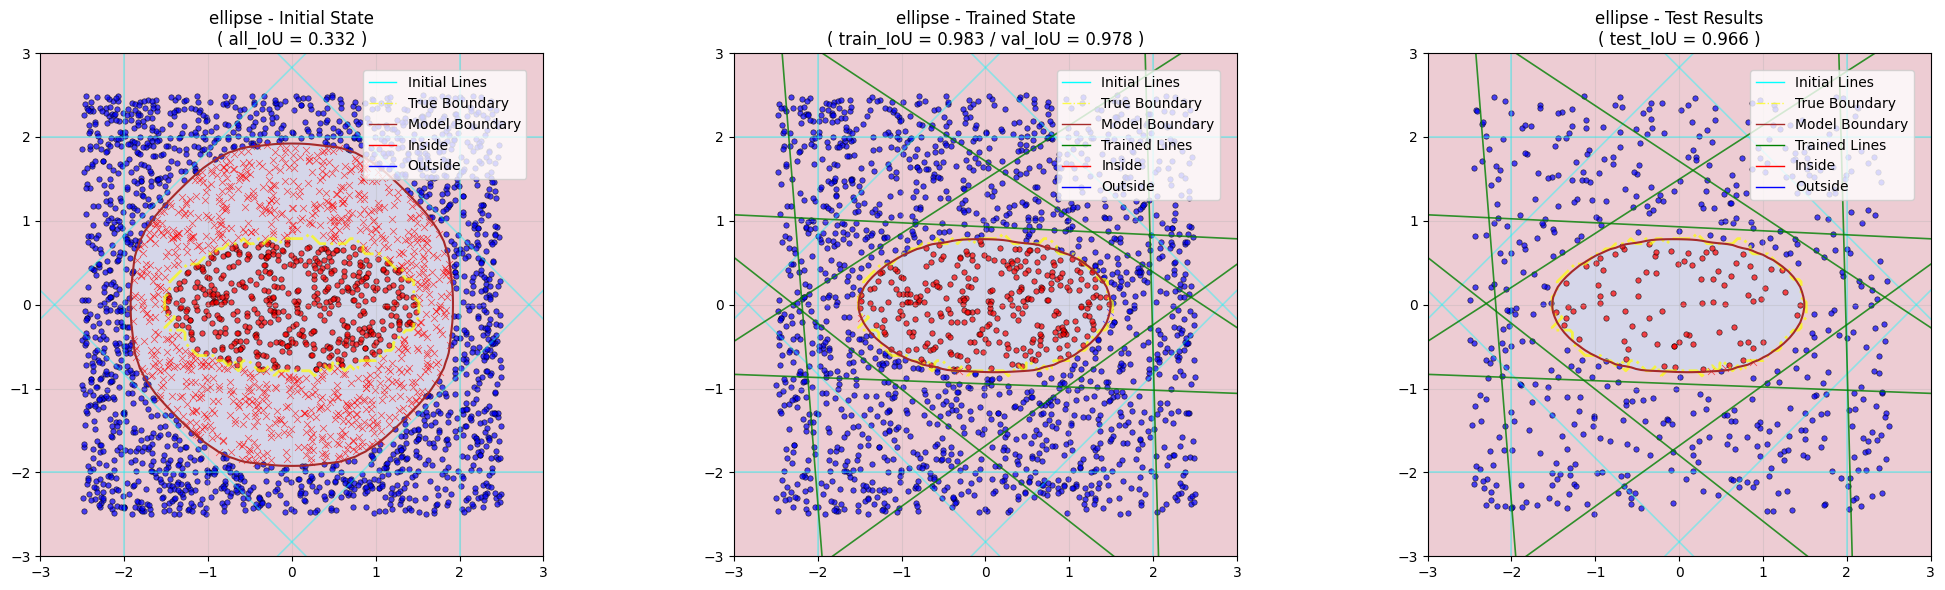

In [8]:
# Ellipse (stretched circle)
ellipse_results = run_model('ellipse', n_sides=8, random_seed=42,
                           radius_x=1.5, radius_y=0.8)

### 8.2 Triangle Classification

Random seed set to: 42

RUNNING Shape: TRIANGLE
Activation: multiply_and_activation
Polygon sides: 6
Random seed: 42
Generated 3000 points for triangle
Inside points: 239.0/3000 (8.0%)
Splitting data. Building model. Initializing model weights. ✓ Model initialization checked! (origin prediction = 1.0000)
Phase 0.1: Training (10 epochs) output layer only
Phase 1: Training (10 epochs) output layer only
Plotting initial model boundaries...
Building KDTree for 3000 data points...
Finding nearest neighbors for 10000 grid points...

Training model...
Phase 2: Training (70 epochs) all layers
Validation IoU: 0.8077
Plotting trained model boundaries...

Testing model...
Test IoU: 0.9286 
Plotting test model boundaries...


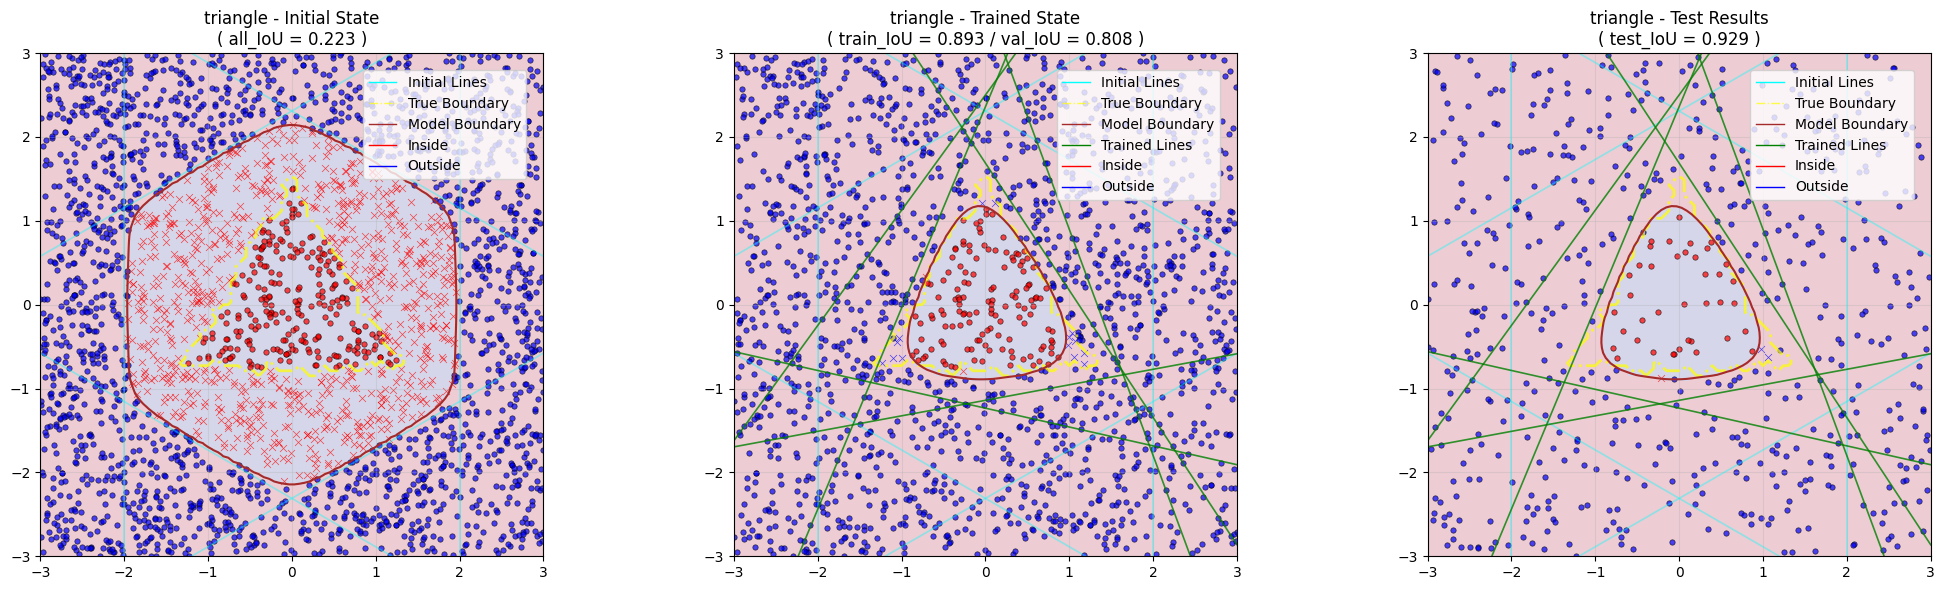

Random seed set to: 42

RUNNING Shape: TRIANGLE
Activation: multiply_and_activation
Polygon sides: 8
Random seed: 42
Generated 3000 points for triangle
Inside points: 171.0/3000 (5.7%)
Splitting data. Building model. Initializing model weights. ✓ Model initialization checked! (origin prediction = 1.0000)
Phase 0.1: Training (10 epochs) output layer only
Phase 1: Training (10 epochs) output layer only
Plotting initial model boundaries...
Building KDTree for 3000 data points...
Finding nearest neighbors for 10000 grid points...

Training model...
Phase 2: Training (70 epochs) all layers
Validation IoU: 0.7949
Plotting trained model boundaries...

Testing model...
Test IoU: 0.7419 
Plotting test model boundaries...


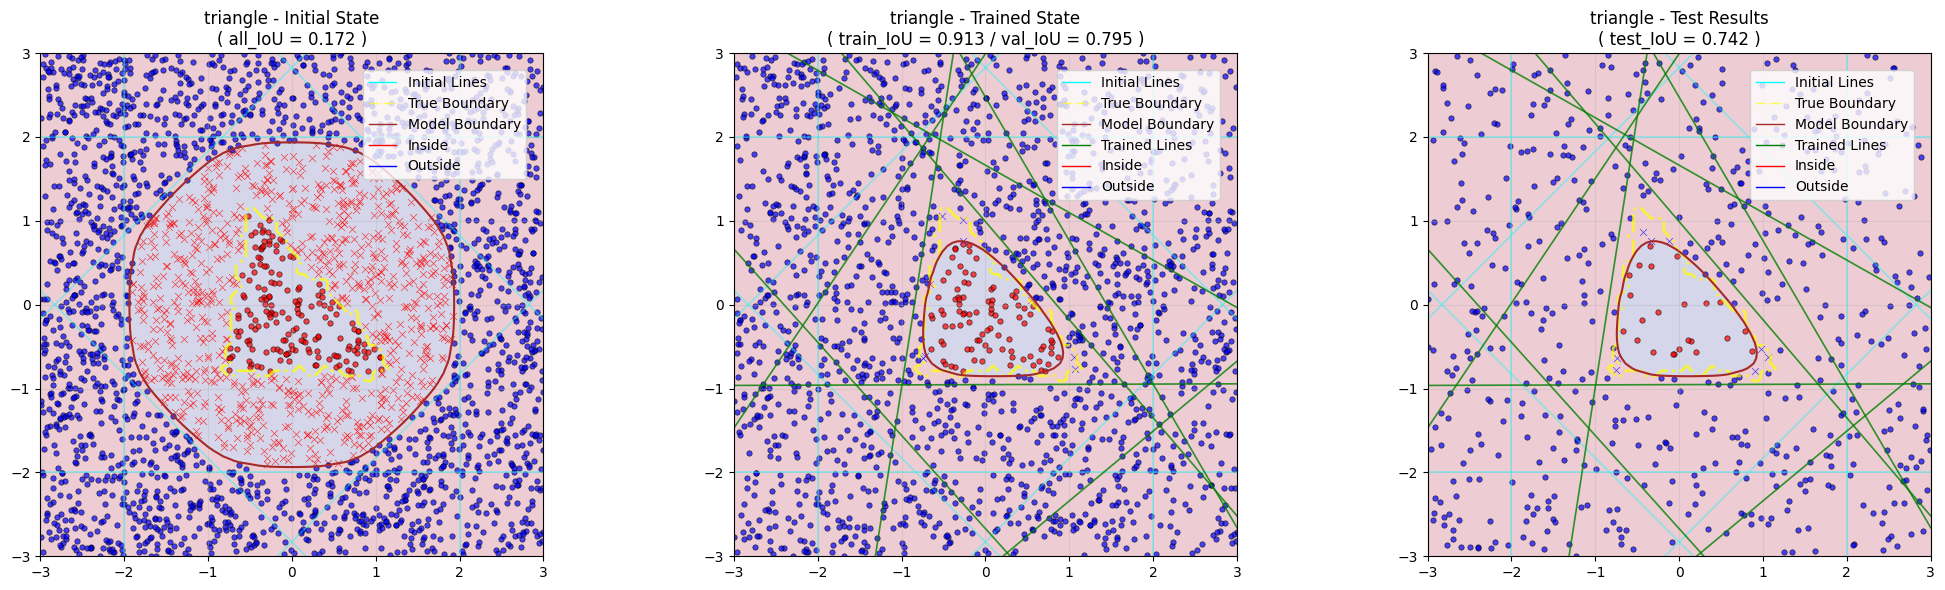

In [9]:
# Equilateral triangle (default from polygon function)
triangle_results = run_model('triangle', n_sides=6, random_seed=42)

# Custom triangle 
custom_triangle = [(-0.5, 1.3), (-0.8, -0.8), (1.2, -0.8)]
custom_triangle_results = run_model('triangle', n_sides=8, random_seed=42,
                                   corners=custom_triangle)

### 8.3 Complex Polygon Shapes

**Note**: The multiply-all approach works best with **convex** shapes. Non-convex shapes like L-shapes will show the limitations of this method.

Random seed set to: 42

RUNNING Shape: HOUSE SHAPE
Activation: multiply_and_activation
Polygon sides: 6
Random seed: 42
Generated 3000 points for house shape
Inside points: 251.0/3000 (8.4%)
Splitting data. Building model. Initializing model weights. ✓ Model initialization checked! (origin prediction = 1.0000)
Phase 0.1: Training (10 epochs) output layer only
Phase 1: Training (10 epochs) output layer only
Plotting initial model boundaries...
Building KDTree for 3000 data points...
Finding nearest neighbors for 10000 grid points...

Training model...
Phase 2: Training (70 epochs) all layers
Validation IoU: 0.9000
Plotting trained model boundaries...

Testing model...
Test IoU: 0.8868 
Plotting test model boundaries...


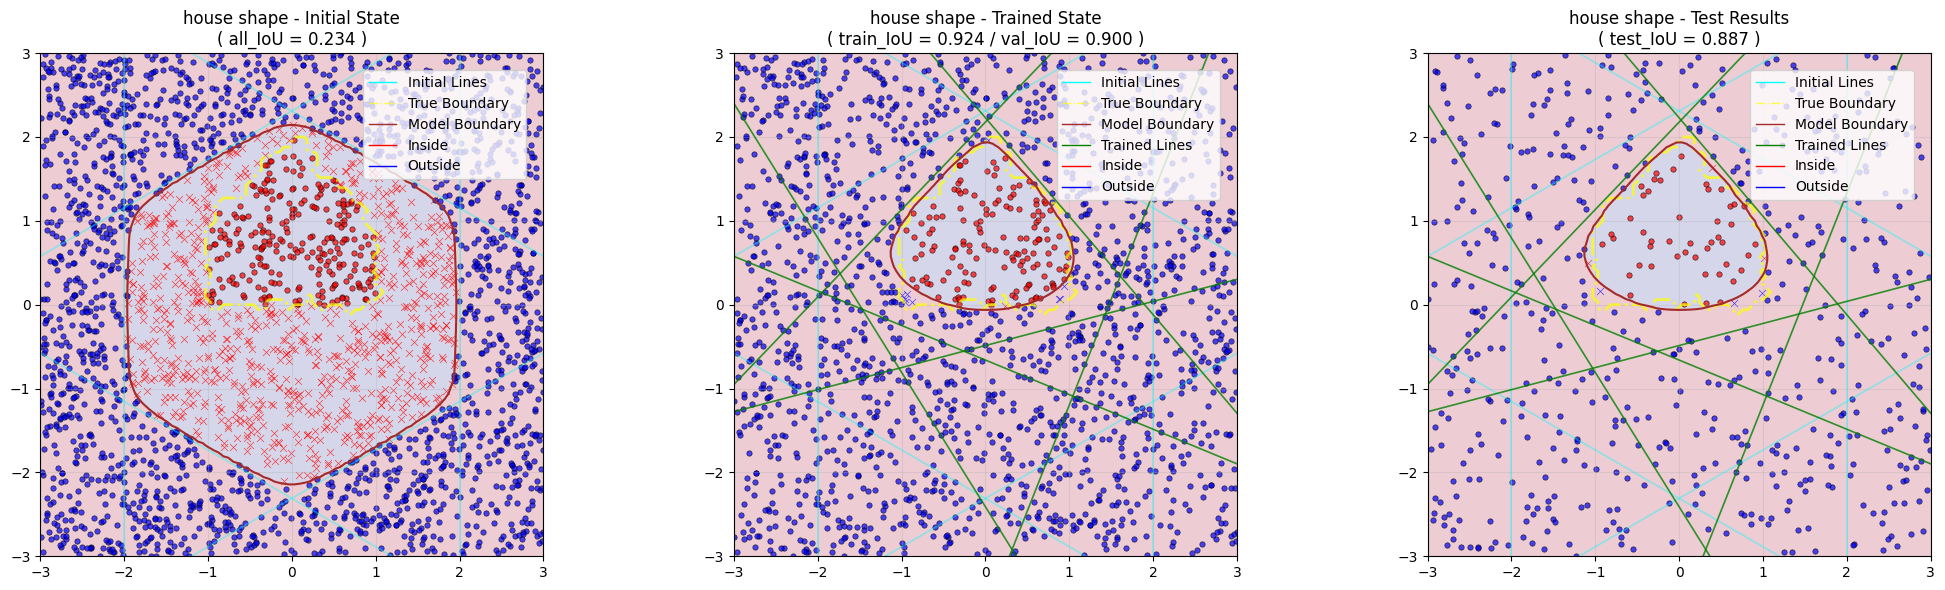

Random seed set to: 42

RUNNING Shape: DIAMOND SHAPE
Activation: multiply_and_activation
Polygon sides: 8
Random seed: 42
Generated 3000 points for diamond shape
Inside points: 238.0/3000 (7.9%)
Splitting data. Building model. Initializing model weights. ✓ Model initialization checked! (origin prediction = 1.0000)
Phase 0.1: Training (10 epochs) output layer only
Phase 1: Training (10 epochs) output layer only
Plotting initial model boundaries...
Building KDTree for 3000 data points...
Finding nearest neighbors for 10000 grid points...

Training model...
Phase 2: Training (70 epochs) all layers
Validation IoU: 0.8958
Plotting trained model boundaries...

Testing model...
Test IoU: 0.8889 
Plotting test model boundaries...


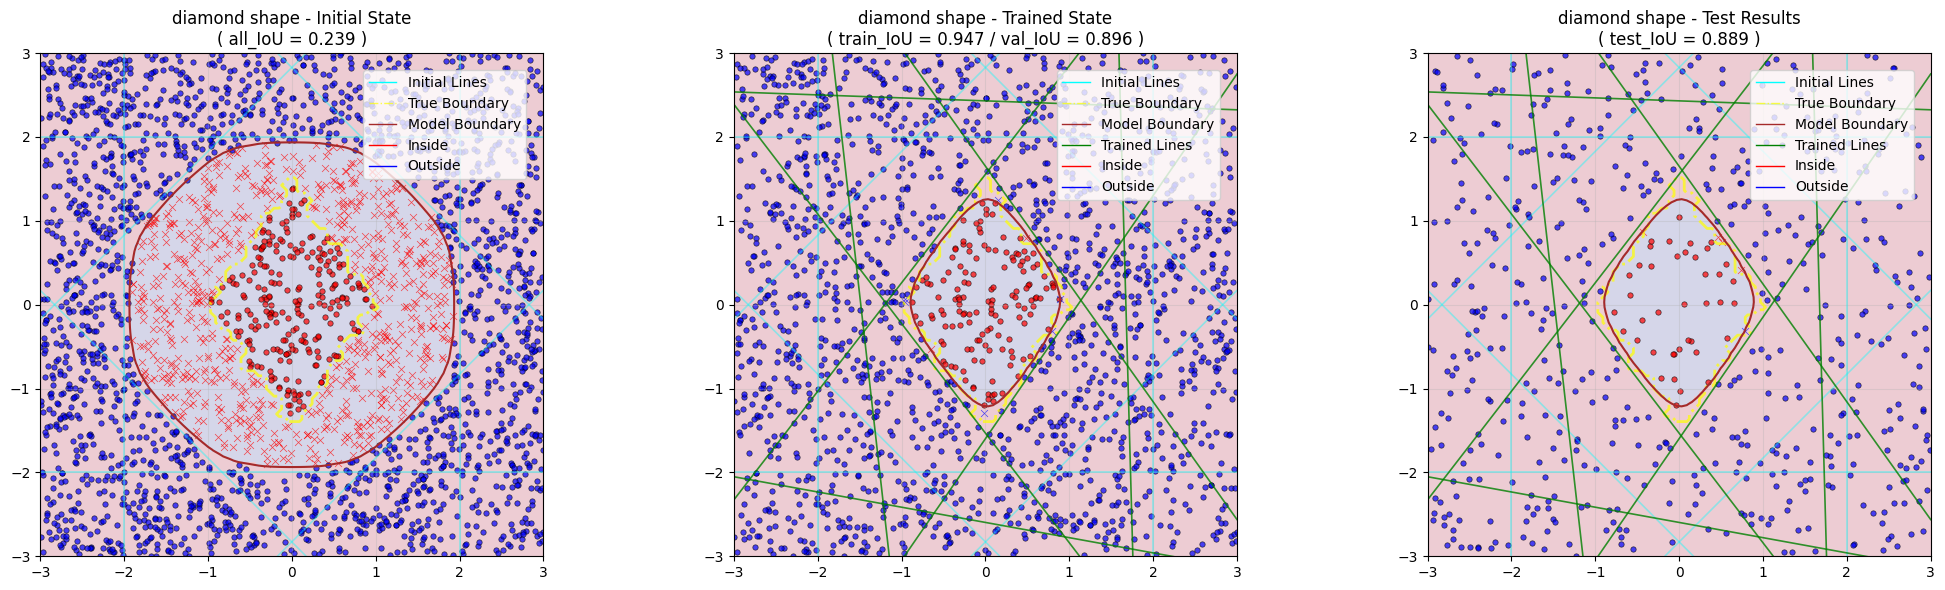

Random seed set to: 42

RUNNING Shape: PENTAGON SHAPE
Activation: multiply_and_activation
Polygon sides: 8
Random seed: 42
Generated 3000 points for pentagon shape
Inside points: 188.0/3000 (6.3%)
Splitting data. Building model. Initializing model weights. ✓ Model initialization checked! (origin prediction = 1.0000)
Phase 0.1: Training (10 epochs) output layer only
Phase 1: Training (10 epochs) output layer only
Plotting initial model boundaries...
Building KDTree for 3000 data points...
Finding nearest neighbors for 10000 grid points...

Training model...
Phase 2: Training (70 epochs) all layers
Validation IoU: 0.7778
Plotting trained model boundaries...

Testing model...
Test IoU: 0.8889 
Plotting test model boundaries...


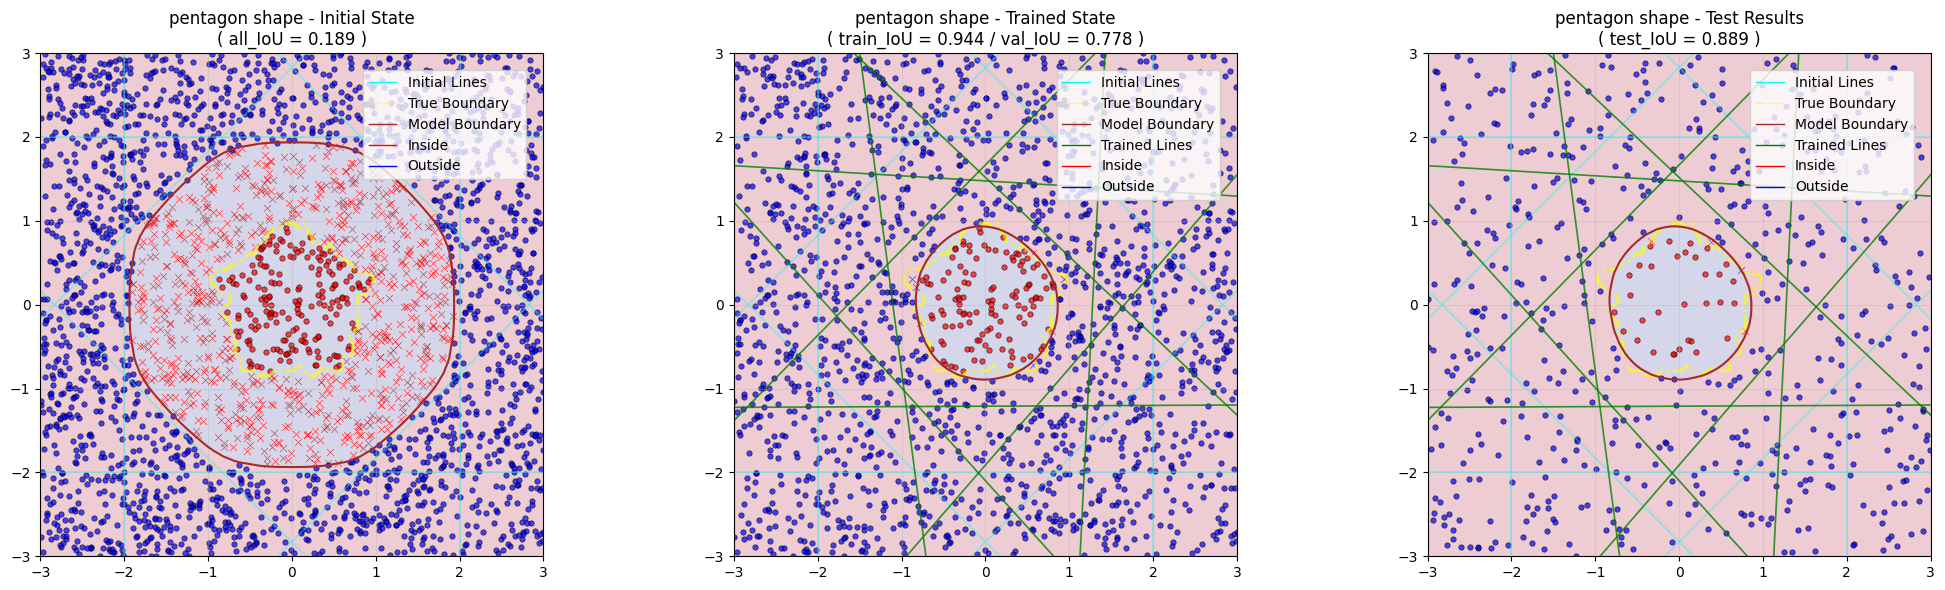

In [10]:
# House shape (convex)
house_corners = [(-1, 0), (1, 0), (1, 1), (0, 2), (-1, 1)]
house_results = run_model('house shape', n_sides=6, random_seed=42,
                         corners=house_corners)

# Diamond
diamond_corners = [(0, 1.5), (1, 0), (0, -1.5), (-1, 0)]
diamond_results = run_model('diamond shape', n_sides=8, random_seed=42,
                           corners=diamond_corners)

# Pentagon
pentagon_corners = [(0, 1), (0.95, 0.31), (0.59, -0.81), (-0.59, -0.81), (-0.95, 0.31)]
pentagon_results = run_model('pentagon shape', n_sides=8, random_seed=42,
                            corners=pentagon_corners)




### 8.4 Non-convex Polygon Shapes

Non-convex shapes like L-shapes, S-shape will show the limitations of this method.

Random seed set to: 42

RUNNING Shape: L-SHAPE
Activation: multiply_and_activation
Polygon sides: 6
Random seed: 42
Generated 3000 points for L-shape
Inside points: 578.0/3000 (19.3%)
Splitting data. Building model. Initializing model weights. ✓ Model initialization checked! (origin prediction = 1.0000)
Phase 0.1: Training (10 epochs) output layer only
Phase 1: Training (10 epochs) output layer only
Plotting initial model boundaries...
Building KDTree for 3000 data points...
Finding nearest neighbors for 10000 grid points...

Training model...
Phase 2: Training (70 epochs) all layers
Validation IoU: 0.5792
Plotting trained model boundaries...

Testing model...
Test IoU: 0.6706 
Plotting test model boundaries...


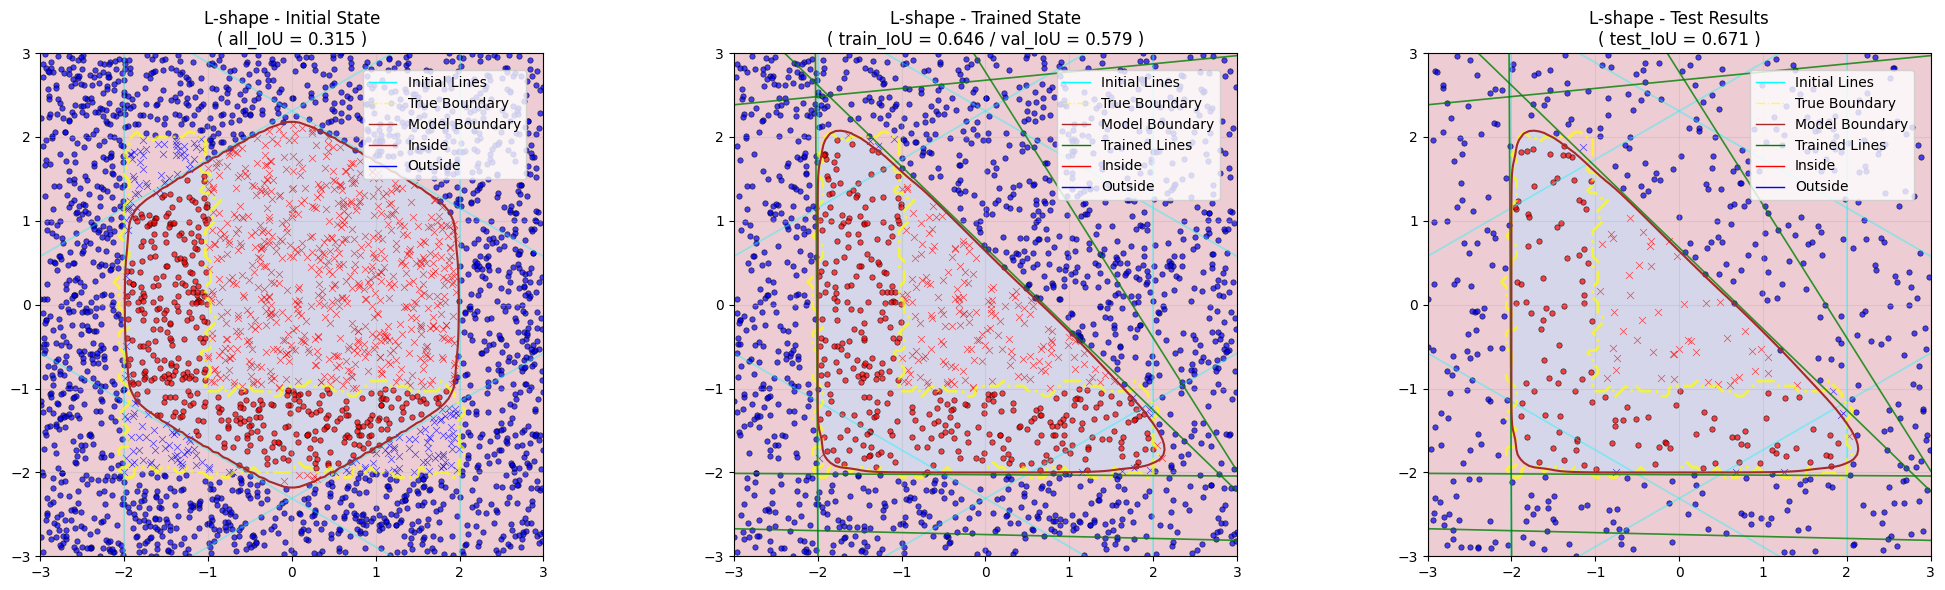

In [11]:
# L-shape (non-convex - demonstrates limitations)
l_shape_corners = [(-2, -2), (2, -2), (2, -1), (-1, -1), (-1, 2), (-2, 2)]
l_shape_results = run_model('L-shape', n_sides=6, random_seed=42, corners=l_shape_corners) # See what happens for n_sides = 3 😉

Random seed set to: 42

RUNNING Shape: S-SHAPE
Activation: multiply_and_activation
Polygon sides: 12
Random seed: 42
Generated 3000 points for S-shape
Inside points: 565.0/3000 (18.8%)
Splitting data. Building model. Initializing model weights. ✓ Model initialization checked! (origin prediction = 1.0000)
Phase 0.1: Training (10 epochs) output layer only
Phase 1: Training (10 epochs) output layer only
Plotting initial model boundaries...
Building KDTree for 3000 data points...
Finding nearest neighbors for 10000 grid points...

Training model...
Phase 2: Training (70 epochs) all layers
Validation IoU: 0.4223
Plotting trained model boundaries...

Testing model...
Test IoU: 0.4155 
Plotting test model boundaries...


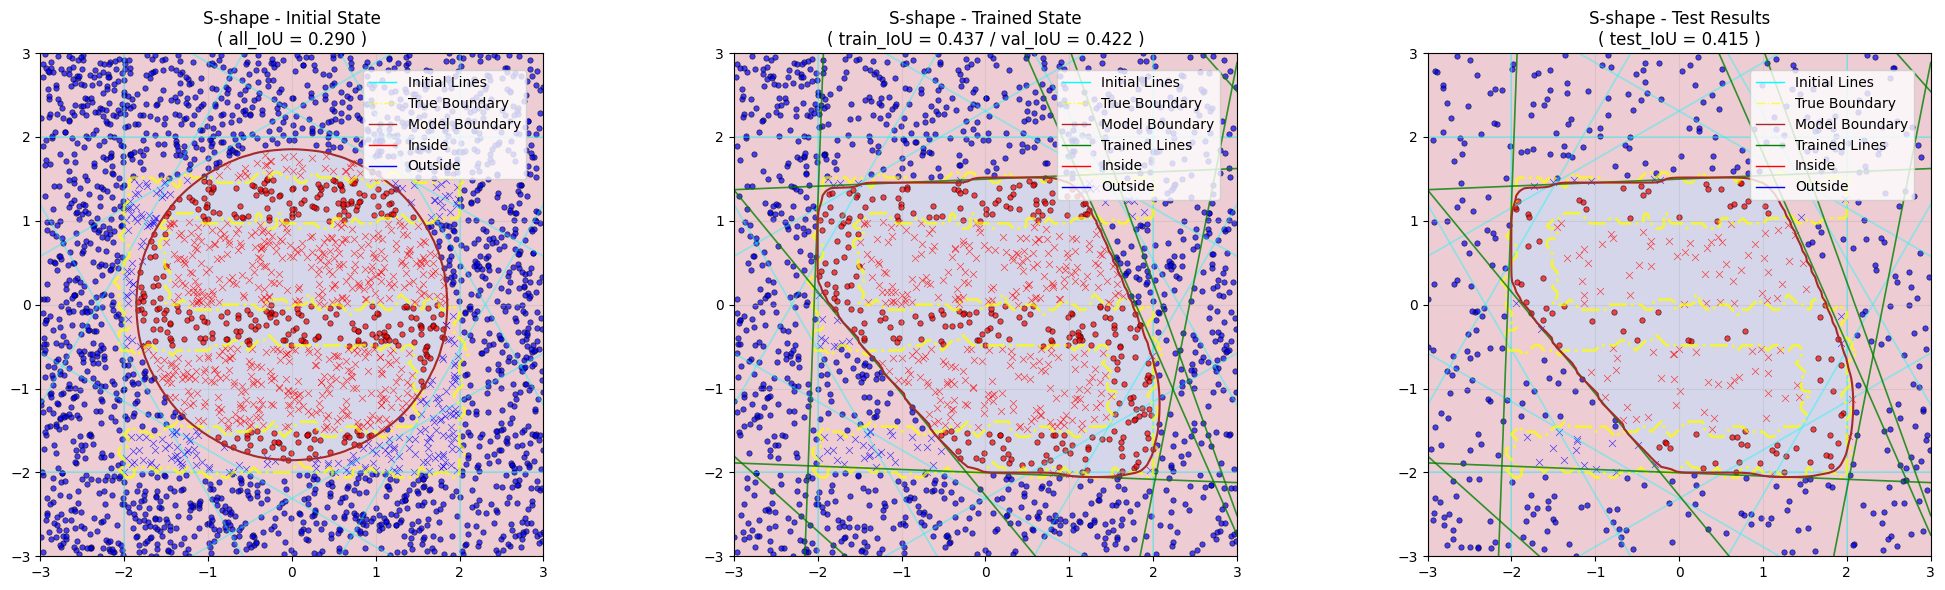

In [12]:
# blocky "S" shaped region 
# (convex approximation of a more complex shape)
#
# NOTE: The model (intersection of half-planes) will approximate only a convex region.
# Increasing n_sides tightens the convex hull but never reproduces concavities.

    # Bottom-left start
    # (-2.0,  -2.0),  
    # go 4 right, 2 up, 3.5 left, 1 up, 3.5 right, 1 up, 4 left, 2 down, 3.5 right, 1 down, 3.5 left
s_shape_corners = [
    (-2.0, -2.0),   # Start
    (2.0, -2.0),    # 4 right
    (2.0, 0.0),     # 2 up
    (-1.5, 0.0),    # 3.5 left
    (-1.5, 1.0),    # 1 up
    (2.0, 1.0),     # 3.5 right
    (2.0, 1.5),     # 0.5 up
    (-2.0, 1.5),    # 4 left
    (-2.0, -0.5),    # 2 down
    (1.5, -0.5),     # 3.5 right
    (1.5, -1.5),    # 1 down
    (-2.0, -1.5),   # 3.5 left
]
    # Implicit close back to (-2.0, 2.5)

# Try n_sides {6, 8, 10, 12, 14}. Fewer → looser hull; more → tighter convex wrap.

s_shape_results = run_model('S-shape', n_sides=12, random_seed=42, corners=s_shape_corners)

## 9. Results Analysis and Comparison

**Performance Summary Placeholder**: *[Insert table/chart showing IoU results for all tested shapes]*

### Key Observations:

1. **Convex Shapes**: The model performs (very) well on convex shapes (circles, triangles, convex polygons)
2. **Non-Convex Limitations**: L-shapes and other non-convex shapes show reduced IoU due to mathematical constraints
3. **Activation Functions**: Both multiply-all and log-multiply variants work well, with slight differences in numerical stability
4. **Hyperplane Visualization**: The learned decision boundaries clearly show the polygon approximation approach

In [13]:
# Collect all results for analysis
all_results = []

EXCELLENT_IOU = 0.95
GOOD_IOU = 0.80
FAIR_IOU = 0.75



# Add results from experiments (you'll need to run the cells above first)
try:
    all_results.extend([
        ('Circle', circle_results['n_sides'], circle_results['iou'], 'Convex'),
        ('Ellipse', ellipse_results['n_sides'], ellipse_results['iou'], 'Convex'),
        ('Triangle', triangle_results['n_sides'], triangle_results['iou'], 'Convex'),
        ('Custom Triangle', custom_triangle_results['n_sides'], custom_triangle_results['iou'], 'Convex'),
        ('House', house_results['n_sides'], house_results['iou'], 'Convex'),
        ('Diamond', diamond_results['n_sides'], diamond_results['iou'], 'Convex'),
        ('Pentagon', pentagon_results['n_sides'], pentagon_results['iou'], 'Convex'),
        ('L-Shape', l_shape_results['n_sides'], l_shape_results['iou'], 'Non-Convex'),
        ('S-Shape', s_shape_results['n_sides'], s_shape_results['iou'], 'Non-Convex'),
    ])
    
    print("COMPREHENSIVE RESULTS SUMMARY")
    print("=" * 60)
    print(f"{'Shape':<15} {'Sides':<6} {'IoU':<10} {'Type':<12} {'Performance'}")
    print("-" * 60)
    
    convex_ious, nonconvex_ious = [], []
    
    for shape, n_sides, iou, shape_type in all_results:
        performance = "Excellent" if iou > EXCELLENT_IOU else "Good" if iou > GOOD_IOU else "Fair" if iou > FAIR_IOU else "Limited"


        print(f"{shape:<15}  {n_sides:>2}    {iou:<10.4f} {shape_type:<12} {performance}")

        if shape_type == 'Convex':
            convex_ious.append(iou)
        else:
            nonconvex_ious.append(iou)
    
    print("-" * 60)
    print(f"Average Convex IoU:     {np.mean(convex_ious):.4f}")
    print(f"Average Non-Convex IoU: {np.mean(nonconvex_ious):.4f}")
    print("=" * 60)
    
except NameError:
    print("⚠️  Run the experiment cells above first to generate results")
    print("Then run this cell again for the comprehensive analysis")

COMPREHENSIVE RESULTS SUMMARY
Shape           Sides  IoU        Type         Performance
------------------------------------------------------------
Circle            5    0.9630     Convex       Excellent
Ellipse           8    0.9783     Convex       Excellent
Triangle          6    0.8077     Convex       Good
Custom Triangle   8    0.7949     Convex       Fair
House             6    0.9000     Convex       Good
Diamond           8    0.8958     Convex       Good
Pentagon          8    0.7778     Convex       Fair
L-Shape           6    0.5792     Non-Convex   Limited
S-Shape          12    0.4223     Non-Convex   Limited
------------------------------------------------------------
Average Convex IoU:     0.8739
Average Non-Convex IoU: 0.5008


## 10. Conclusion and Next Steps

In this study, we explored how **custom activation functions** based on multiplication can act as logical AND gates to combine half-plane constraints into convex polygon boundaries.
This approach blends **geometric interpretability** with the flexibility of neural networks, providing an intuitive method for binary shape classification.

**Key takeaways:**
- Convex shapes can be modeled as intersections of half-planes (ReLU neurons).
- Logical AND via multiplication enforces *all* constraints simultaneously.
- Geometric initialization can speed up convergence and improve stability.

**Next steps and ongoing work:**
- Exploring extensions to **3D shapes** and **higher-dimensional convex sets**.
- Investigating **dynamic neuron allocation** based on misclassified regions (data-driven polygon refinement).
- Comparing against standard deep learning classifiers to quantify efficiency and interpretability gains.

Stay tuned for the **follow-up notebook** covering the concave/donut shape classification problem.
